In [117]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import warnings
import os
warnings.filterwarnings('ignore')

In [118]:
print(" Memulai pipeline pengolahan data saham menit-per-menit...\n")

# --------------------------
# Konfigurasi
# --------------------------
API_KEY = "ZZKH1D261UFWVJEE"
SYMBOL = "GOOG"
INTERVAL = "1min"
months = [
    "2025-01", "2025-02", "2025-03", "2025-04", "2025-05",
    "2025-06", "2025-07", "2025-08", "2025-09", "2025-10", "2025-11"
]

 Memulai pipeline pengolahan data saham menit-per-menit...



# **Persiapan Data**

In [119]:
# ============================================================
# Langkah 0: Ambil Data Mentah dari File Lokal atau Alpha Vantage API
# ============================================================

import os
import requests
import pandas as pd
import time

print("Langkah 0: Mengecek apakah file data mentah sudah tersedia...\n")

# --------------------------
# 1️⃣ Jika file lokal sudah ada → baca dari CSV
# --------------------------
if os.path.exists("data_mentah.csv"):
    print("📂 File 'data_mentah.csv' ditemukan! Membaca dari file lokal...\n")

    # Baca CSV
    df_raw = pd.read_csv("data_mentah.csv", index_col=0)

    # Pastikan index berupa datetime (termasuk jika sudah tz-aware)
    try:
        df_raw.index = pd.to_datetime(df_raw.index, errors='coerce', utc=True)
    except Exception as e:
        print("⚠️ Tidak dapat mengonversi index ke datetime:", e)

    # Tangani timezone dengan deteksi otomatis
    if getattr(df_raw.index, 'tz', None) is not None:
        df_raw.index = df_raw.index.tz_convert('US/Eastern')
        print("🌐 Index sudah memiliki timezone → dikonversi ke US/Eastern.\n")
    else:
        df_raw.index = df_raw.index.tz_localize('US/Eastern')
        print("🕒 Index belum memiliki timezone → dilokalisasi ke US/Eastern.\n")

    print(f"✅ Data berhasil dibaca dari file lokal. Total baris: {len(df_raw):,}\n")
    print("Beberapa baris teratas:")
    print(df_raw.head())

# --------------------------
# 2️⃣ Jika file belum ada → ambil dari Alpha Vantage API (multi-bulan)
# --------------------------
else:
    print("❌ File 'data_mentah.csv' tidak ditemukan. Mengambil data mentah dari Alpha Vantage API...\n")

    all_dataframes = []

    for month in months:
        print(f"  Mengambil data untuk bulan: {month}...")
        url = "https://www.alphavantage.co/query"
        params = {
            "function": "TIME_SERIES_INTRADAY",
            "symbol": SYMBOL,
            "interval": INTERVAL,
            "month": month,
            "outputsize": "full",
            "extended_hours": "false",  # Hanya jam reguler (09:30–16:00 ET)
            "apikey": API_KEY
        }

        response = requests.get(url, params=params)
        data = response.json()

        if "Error Message" in data:
            print(f"    ❌ Error: {data['Error Message']}")
            continue
        if "Note" in data:
            print(f"    ⚠️  Rate limit: {data['Note']}")
            time.sleep(60)
            continue

        time_series_key = [k for k in data.keys() if "Time Series" in k]
        if not time_series_key:
            print(f"    ❌ Tidak ada data untuk {month}")
            continue

        raw_data = data[time_series_key[0]]
        df_month = pd.DataFrame.from_dict(raw_data, orient='index')

        # Konversi index ke datetime dan set timezone ke US/Eastern
        df_month.index = pd.to_datetime(df_month.index, errors='coerce')
        df_month = df_month.dropna(subset=df_month.columns)
        df_month.index = df_month.index.tz_localize('US/Eastern')

        df_month = df_month.sort_index()

        # Rename kolom
        df_month.rename(columns={
            '1. open': 'open',
            '2. high': 'high',
            '3. low': 'low',
            '4. close': 'close',
            '5. volume': 'volume'
        }, inplace=True)

        # Konversi ke numerik
        for col in ['open', 'high', 'low', 'close', 'volume']:
            df_month[col] = pd.to_numeric(df_month[col], errors='coerce')

        print(f"    ✅ Berhasil: {len(df_month)} baris")
        all_dataframes.append(df_month)

        time.sleep(12)  # Hindari rate limit (maks 5 call/menit)

    # Gabungkan semua data
    if not all_dataframes:
        raise ValueError("Tidak ada data yang berhasil diambil dari API.")

    df_raw = pd.concat(all_dataframes, sort=True)
    df_raw = df_raw[~df_raw.index.duplicated(keep='first')]
    df_raw = df_raw.sort_index()

    # ✅ Simpan data mentah ke CSV (dengan timezone)
    df_raw.to_csv("data_mentah.csv")

    raw_rows = len(df_raw)
    raw_na = df_raw[["open", "high", "low", "close", "volume"]].isna().sum().sum()

    print(f"\nData mentah berhasil diambil dan disimpan:")
    print(f"   - Total baris: {raw_rows:,}")
    print(f"   - NaN pada OHLCV: {raw_na}")
    print(f"   - Rentang waktu: {df_raw.index.min()} → {df_raw.index.max()}\n")


Langkah 0: Mengecek apakah file data mentah sudah tersedia...

📂 File 'data_mentah.csv' ditemukan! Membaca dari file lokal...

🌐 Index sudah memiliki timezone → dikonversi ke US/Eastern.

✅ Data berhasil dibaca dari file lokal. Total baris: 83,458

Beberapa baris teratas:
                             close     high      low     open  volume
2025-01-02 09:30:00-05:00 191.2687 191.6126 190.4165 190.8600  687402
2025-01-02 09:31:00-05:00 190.6059 191.3136 190.3667 191.2737   87780
2025-01-02 09:32:00-05:00 190.3353 190.6475 190.1623 190.5660   61234
2025-01-02 09:33:00-05:00 189.4796 190.4165 189.4447 190.4065   75754
2025-01-02 09:34:00-05:00 189.5111 189.7985 189.4596 189.5493   65696


In [120]:
# --------------------------
# Langkah 1: Validasi rentang waktu (opsional)
# --------------------------
print("Langkah 1: Validasi rentang waktu jam perdagangan...")

market_open = pd.to_datetime("09:30:00").time()
market_close = pd.to_datetime("16:00:00").time()

# Cek apakah ada data di luar jam perdagangan
out_of_hours = df_raw[
    (df_raw.index.time < market_open) | (df_raw.index.time > market_close)
]

if out_of_hours.empty:
    print("Semua data sudah berada dalam jam perdagangan reguler (API sudah filter).")
    df_trading = df_raw.copy()
else:
    print(f"Ditemukan {len(out_of_hours):,} baris di luar jam reguler — akan difilter.")
    df_trading = df_raw[
        (df_raw.index.dayofweek < 5) &
        (df_raw.index.time >= market_open) &
        (df_raw.index.time <= market_close)
    ].copy()

# Reset index agar 'timestamp' jadi kolom biasa
df_trading = df_trading.reset_index().rename(columns={'index': 'timestamp'})
df_trading['timestamp'] = df_trading['timestamp'].dt.tz_convert(None)

Langkah 1: Validasi rentang waktu jam perdagangan...
Semua data sudah berada dalam jam perdagangan reguler (API sudah filter).


In [121]:
# --------------------------
# Langkah 2: Validasi Awal (Sebelum Cleaning)
# --------------------------
print("Langkah 2: Validasi awal (sebelum cleaning)...")

# Cek NaN
na_ohlc = df_trading[["open", "high", "low", "close"]].isna().sum().sum()
na_vol = df_trading["volume"].isna().sum()

# Cek duplikat
dup_ts = df_trading["timestamp"].duplicated().sum()

# Cek harga <= 0
invalid_price = df_trading[
    (df_trading["open"] <= 0) | (df_trading["high"] <= 0) |
    (df_trading["low"] <= 0) | (df_trading["close"] <= 0)
].shape[0]

# Cek gap >1 menit
df_sorted = df_trading.sort_values("timestamp").reset_index(drop=True)
df_sorted["time_diff"] = df_sorted["timestamp"].diff().dt.total_seconds() / 60
gaps_initial = df_sorted[df_sorted["time_diff"] > 1].shape[0]

print(f"Validasi awal:")
print(f"   - NaN pada OHLC: {na_ohlc}")
print(f"   - NaN pada volume: {na_vol}")
print(f"   - Duplikat timestamp: {dup_ts}")
print(f"   - Harga ≤ 0: {invalid_price}")
print(f"   - Gap >1 menit: {gaps_initial:,}")
print()

Langkah 2: Validasi awal (sebelum cleaning)...
Validasi awal:
   - NaN pada OHLC: 0
   - NaN pada volume: 0
   - Duplikat timestamp: 0
   - Harga ≤ 0: 0
   - Gap >1 menit: 215



In [122]:
# --------------------------
# Langkah 3: Data Cleaning
# --------------------------
print("Langkah 3: Melakukan data cleaning...")

df_clean = df_trading.copy()
# Hapus NaN di OHLCV
df_clean = df_clean.dropna(subset=["open", "high", "low", "close", "volume"])
# Hapus duplikat
df_clean = df_clean.drop_duplicates(subset=["timestamp"], keep="first")
# Hapus harga tidak valid
df_clean = df_clean[
    (df_clean["open"] > 0) & (df_clean["high"] > 0) &
    (df_clean["low"] > 0) & (df_clean["close"] > 0)
]
df_clean = df_clean.sort_values("timestamp").reset_index(drop=True)

raw_rows = len(df_raw)
clean_rows = len(df_clean)

print(f"Setelah cleaning:")
print(f"   - Baris akhir: {clean_rows:,}")
print(f"   - Baris dihapus: {raw_rows - clean_rows:,}\n")

Langkah 3: Melakukan data cleaning...
Setelah cleaning:
   - Baris akhir: 83,458
   - Baris dihapus: 0



In [123]:
import pandas as pd

print("Langkah 4: Mengisi data yang hilang dalam jam perdagangan (09:30–15:59) dengan interpolasi...")

# 1. Baca data mentah
df_raw = df_raw.copy()
df_raw.index = pd.to_datetime(df_raw.index, utc=True)
df_raw.index = df_raw.index.tz_convert('US/Eastern')

# 2. Reset index
df = df_raw.reset_index().rename(columns={'index': 'timestamp'})

# 3. Bersihkan dasar (opsional tapi disarankan)
df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], how='all')
df = df[(df[['open', 'high', 'low', 'close']] > 0).all(axis=1) & (df['volume'] >= 0)]

# 4. Filter hari kerja
df = df[df['timestamp'].dt.dayofweek < 5].copy()

# 5. Dapatkan tanggal unik sebagai naive (tanpa timezone)
trading_dates = sorted(df['timestamp'].dt.tz_localize(None).dt.normalize().unique())

# 6. Bangun jadwal ideal: 09:30–15:59 ET
all_timestamps = []
for d in trading_dates:
    start = pd.Timestamp(d) + pd.Timedelta(hours=9, minutes=30)
    end   = pd.Timestamp(d) + pd.Timedelta(hours=15, minutes=59)
    start = start.tz_localize('US/Eastern')
    end   = end.tz_localize('US/Eastern')
    day_range = pd.date_range(start=start, end=end, freq='1T')
    all_timestamps.extend(day_range)

df_schedule = pd.DataFrame({'timestamp': all_timestamps})

# 7. Gabungkan dengan data aktual
df_merged = pd.merge(df_schedule, df, on='timestamp', how='left')

# 8. Tandai baris yang AWALNYA missing (semua OHLCV NaN)
cols = ['open', 'high', 'low', 'close', 'volume']
was_missing = df_merged[cols].isna().all(axis=1)

# 9. Lakukan interpolasi
df_merged[cols] = df_merged[cols].interpolate(method='linear')
df_merged['volume'] = df_merged['volume'].clip(lower=0)

# 10. Setelah interpolasi, cek yang SUDAH TERISI
now_filled = ~df_merged[cols].isna().all(axis=1)
interpolated_mask = was_missing & now_filled
interpolated_timestamps = df_merged.loc[interpolated_mask, 'timestamp'].tolist()

# 11. Simpan hasil akhir
df_final = df_merged.drop(columns=[], errors='ignore')  # simpan semua

# 12. Tampilkan laporan
total_interpolated = len(interpolated_timestamps)
print(f"   ✅ Interpolasi selesai.")
print(f"   - Total menit yang diisi via interpolasi: {total_interpolated}")

if total_interpolated == 0:
    print("   🎯 Tidak ada data yang perlu diinterpolasi.")
else:
    print(f"\n📋 Timestamp yang diinterpolasi:")
    for ts in interpolated_timestamps:
        print(f"  - {ts}")

# Opsional: tampilkan contoh nilai hasil interpolasi
if total_interpolated > 0:
    print(f"\n🔍 Contoh data hasil interpolasi (5 baris pertama):")
    example_rows = df_final[df_final['timestamp'].isin(interpolated_timestamps[:5])]
    print(example_rows[['timestamp', 'open', 'high', 'low', 'close', 'volume']].to_string(index=False))

Langkah 4: Mengisi data yang hilang dalam jam perdagangan (09:30–15:59) dengan interpolasi...
   ✅ Interpolasi selesai.
   - Total menit yang diisi via interpolasi: 2

📋 Timestamp yang diinterpolasi:
  - 2025-07-03 15:29:00-04:00
  - 2025-07-03 15:46:00-04:00

🔍 Contoh data hasil interpolasi (5 baris pertama):
                timestamp     open     high      low    close   volume
2025-07-03 15:29:00-04:00 180.0136 180.1135 179.9886 180.0585 129.5000
2025-07-03 15:46:00-04:00 180.0235 180.0236 180.0235 180.0235 378.5000


In [124]:
# --------------------------
# Langkah 5: Validasi Akhir
# --------------------------
print("Langkah 5: Validasi akhir...")

final_rows = len(df_final) # Tambahkan baris ini

# Cek NaN — HANYA pada kolom yang benar-benar ada
final_na = df_final[["open", "high", "low", "close", "volume"]].isna().sum().sum()

# Cek gap dalam hari
df_final["date"] = df_final["timestamp"].dt.date
df_final["time_diff"] = df_final.groupby("date")["timestamp"].diff().dt.total_seconds() / 60
gaps_final = df_final[df_final["time_diff"] > 1].shape[0]

# Cek harga dan volume
invalid_final = df_final[
    (df_final["open"] <= 0) | (df_final["volume"] < 0)
].shape[0]

print(f"Hasil validasi akhir:")
print(f"   - NaN pada kolom penting: {final_na}")
print(f"   - Gap >1 menit (dalam jam perdagangan): {gaps_final}")
print(f"   - Data tidak valid (harga ≤0 / volume <0): {invalid_final}")
print(f"   - Timestamp berurutan: {'✅' if df_final['timestamp'].is_monotonic_increasing else '❌'}")

if final_na == 0 and gaps_final == 0 and invalid_final == 0:
    print("\nSEMUA VALIDASI LULUS — DATA SIAP UNTUK PREDIKSI!")
else:
    print("\nPeringatan: Beberapa validasi gagal.")

print(f"\nRingkasan Akhir:")
print(f"   - Rentang waktu: {df_final['timestamp'].min()} → {df_final['timestamp'].max()}")
print(f"   - Total data: {final_rows:,} menit perdagangan")
print(f"   - Frekuensi: 1 menit (kontinu selama jam pasar)")

print("\nContoh 5 baris pertama:")
print(df_final.head()[["timestamp", "open", "high", "low", "close", "volume"]])

Langkah 5: Validasi akhir...
Hasil validasi akhir:
   - NaN pada kolom penting: 0
   - Gap >1 menit (dalam jam perdagangan): 0
   - Data tidak valid (harga ≤0 / volume <0): 0
   - Timestamp berurutan: ✅

SEMUA VALIDASI LULUS — DATA SIAP UNTUK PREDIKSI!

Ringkasan Akhir:
   - Rentang waktu: 2025-01-02 09:30:00-05:00 → 2025-11-07 15:59:00-05:00
   - Total data: 83,460 menit perdagangan
   - Frekuensi: 1 menit (kontinu selama jam pasar)

Contoh 5 baris pertama:
                  timestamp     open     high      low    close      volume
0 2025-01-02 09:30:00-05:00 190.8600 191.6126 190.4165 191.2687 687402.0000
1 2025-01-02 09:31:00-05:00 191.2737 191.3136 190.3667 190.6059  87780.0000
2 2025-01-02 09:32:00-05:00 190.5660 190.6475 190.1623 190.3353  61234.0000
3 2025-01-02 09:33:00-05:00 190.4065 190.4165 189.4447 189.4796  75754.0000
4 2025-01-02 09:34:00-05:00 189.5493 189.7985 189.4596 189.5111  65696.0000


In [125]:
df_final.to_csv("dataset.csv", index=False)

In [126]:
# Set style untuk visualisasi profesional
plt.style.use('seaborn-v0_8')
sns.set_palette("tab10")
pd.set_option('display.float_format', '{:.4f}'.format)

# Tambahkan kolom waktu tambahan untuk analisis
df_final['date'] = df_final['timestamp'].dt.date
df_final['hour'] = df_final['timestamp'].dt.hour
df_final['minute'] = df_final['timestamp'].dt.minute
df_final['day_of_week'] = df_final['timestamp'].dt.day_name()
df_final['return'] = df_final['close'].pct_change()

In [127]:
print("Rentang waktu data:")
print(f"Mulai: {df_final['timestamp'].min()}")
print(f"Akhir: {df_final['timestamp'].max()}")
print(f"Jumlah hari perdagangan: {df_final['timestamp'].dt.date.nunique()}")

Rentang waktu data:
Mulai: 2025-01-02 09:30:00-05:00
Akhir: 2025-11-07 15:59:00-05:00
Jumlah hari perdagangan: 214


# **Analisis EDA**

In [128]:
# ===================================================================
# 1. RINGKASAN STATISTIK DASAR
# Tujuan: Memahami skala, variabilitas, dan distribusi data.
# Insight: Apakah harga dan volume berada dalam rentang wajar?
# ===================================================================
print("1.Ringkasan Statistik Dasar")
print("-" * 40)
print(f"Total observasi     : {len(df_final):,}")
print(f"Rentang waktu       : {df_final['timestamp'].min()} → {df_final['timestamp'].max()}")
print(f"Hari perdagangan    : {df_final['date'].nunique()}")
print(f"Kelengkapan data    : {len(df_final) / (df_final['date'].nunique() * 390) * 100:.1f}%\n")

print("Statistik OHLCV:")
display(df_final[['open', 'high', 'low', 'close', 'volume']].describe().round(4))

1.Ringkasan Statistik Dasar
----------------------------------------
Total observasi     : 83,460
Rentang waktu       : 2025-01-02 09:30:00-05:00 → 2025-11-07 15:59:00-05:00
Hari perdagangan    : 214
Kelengkapan data    : 100.0%

Statistik OHLCV:


,open,high,low,close,volume
count,83460.0000,83460.0000,83460.0000,83460.0000,83460.0000
mean,195.7368,195.8334,195.6373,195.7365,47533.9553
std,34.7692,34.7791,34.7603,34.7693,73446.2238
min,142.5734,143.0624,142.3639,142.5555,1.0000
25%,168.9985,169.0871,168.9087,168.9985,19736.7500
50%,186.0508,186.1106,185.9910,186.0508,30672.0000
75%,207.4440,207.5239,207.3718,207.4494,51622.2500
max,291.7200,291.9300,290.3600,290.5100,4282263.0000



2.Tren Harga & Volume dari Waktu ke Waktu
----------------------------------------
Visualisasi harga penutupan dan volume sepanjang periode.


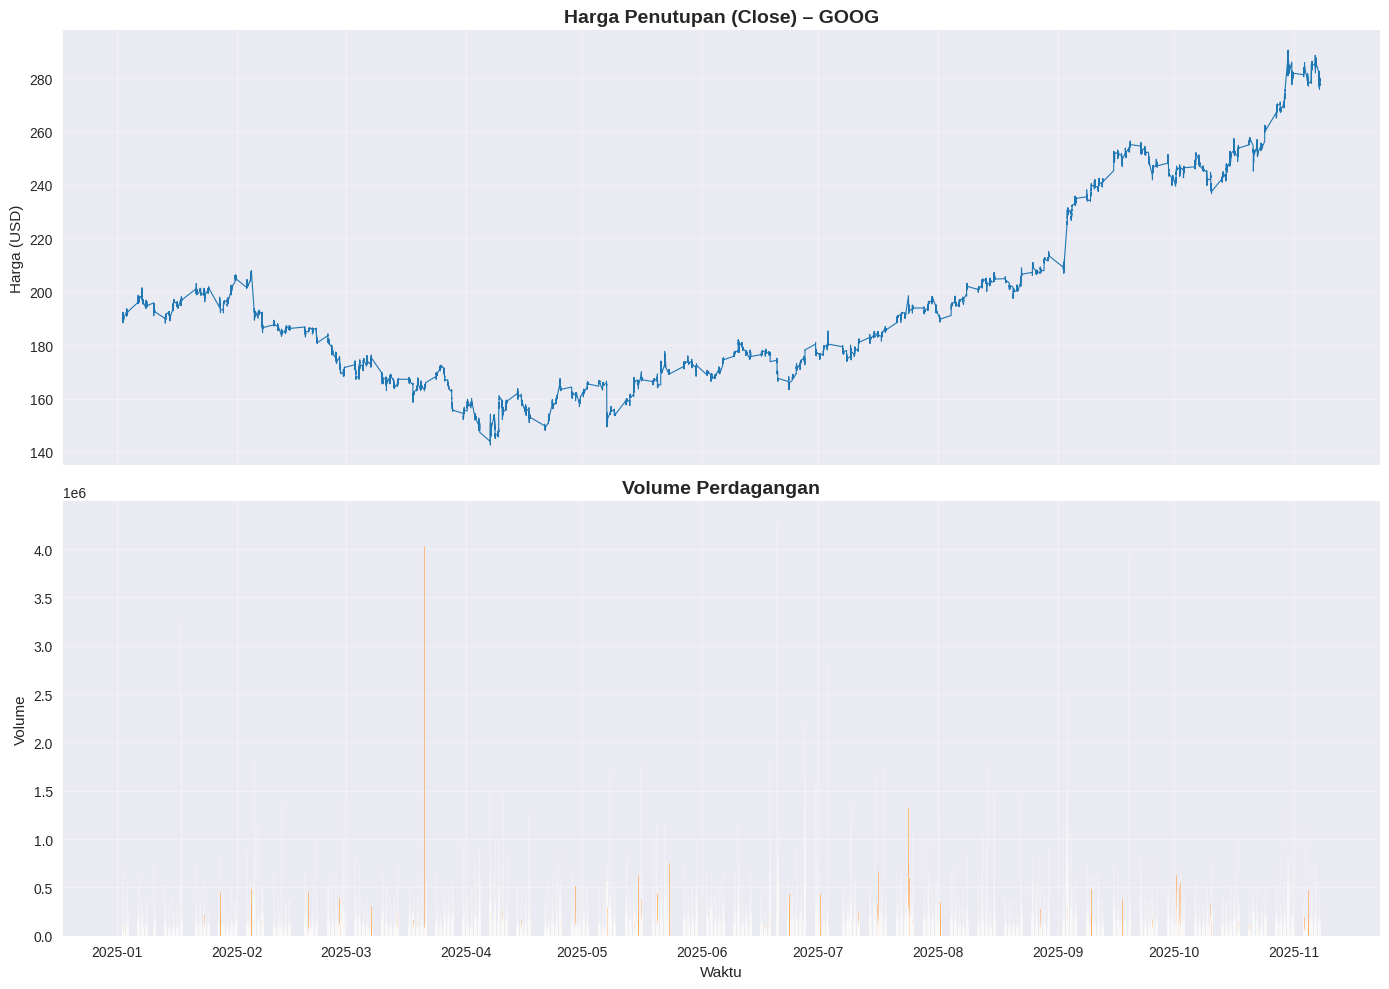

In [129]:
# ===================================================================
# 2. TREN HARGA & VOLUME DARI WAKTU KE WAKTU
# Tujuan: Identifikasi tren jangka panjang, pola musiman, dan event ekstrem.
# Insight: Apakah saham bullish? Kapan volatilitas tinggi?
# ===================================================================
print("\n2.Tren Harga & Volume dari Waktu ke Waktu")
print("-" * 40)
print("Visualisasi harga penutupan dan volume sepanjang periode.")

fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Harga closing
ax[0].plot(df_final['timestamp'], df_final['close'], color='tab:blue', linewidth=0.8)
ax[0].set_title('Harga Penutupan (Close) – GOOG', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Harga (USD)')
ax[0].grid(True, alpha=0.3)

# Volume
ax[1].bar(df_final['timestamp'], df_final['volume'], color='tab:orange', width=0.01, alpha=0.7)
ax[1].set_title('Volume Perdagangan', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Volume')
ax[1].set_xlabel('Waktu')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


3.Distribusi Volume Perdagangan
----------------------------------------
Memahami pola likuiditas: apakah volume terkonsentrasi di waktu tertentu?


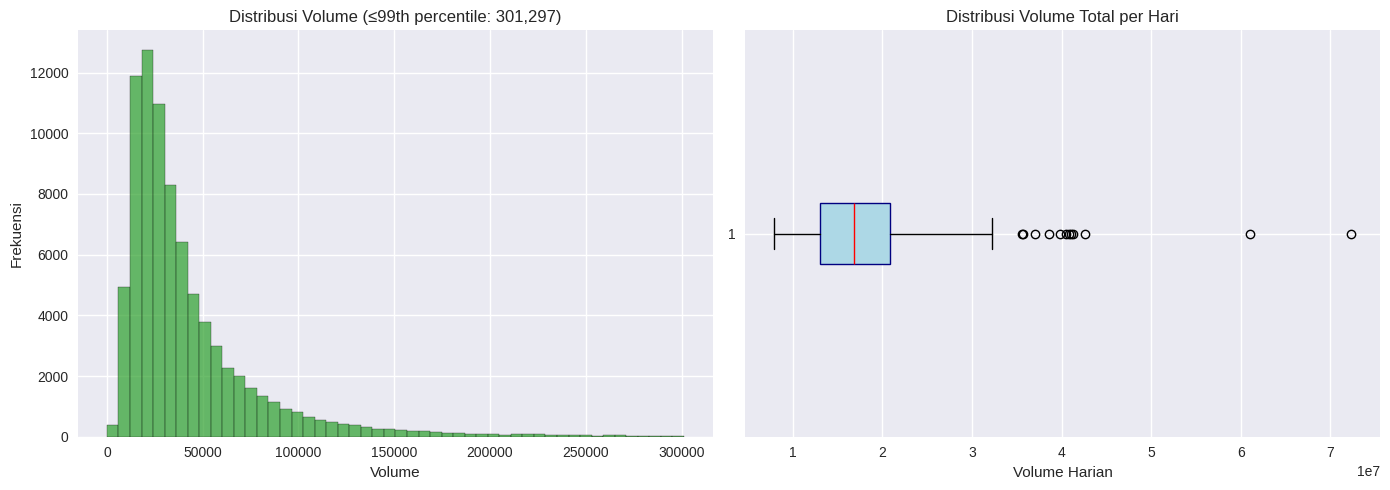

In [130]:
# ===================================================================
# 3. DISTRIBUSI VOLUME PERDAGANGAN
# Tujuan: Pahami sebaran likuiditas dan identifikasi outlier.
# Insight: Sebagian besar menit volume rendah; beberapa event volume tinggi.
# ===================================================================
print("\n3.Distribusi Volume Perdagangan")
print("-" * 40)
print("Memahami pola likuiditas: apakah volume terkonsentrasi di waktu tertentu?")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histogram volume (tanpa 1% outlier teratas)
vol_p99 = df_final['volume'].quantile(0.99)
df_vol_plot = df_final[df_final['volume'] <= vol_p99]

ax[0].hist(df_vol_plot['volume'], bins=50, color='tab:green', alpha=0.7, edgecolor='black')
ax[0].set_title(f'Distribusi Volume (≤99th percentile: {vol_p99:,.0f})')
ax[0].set_xlabel('Volume')
ax[0].set_ylabel('Frekuensi')

# Boxplot volume harian
daily_volume = df_final.groupby('date')['volume'].sum()
ax[1].boxplot(daily_volume, vert=False, patch_artist=True,
              boxprops=dict(facecolor='lightblue', color='navy'),
              medianprops=dict(color='red'))
ax[1].set_title('Distribusi Volume Total per Hari')
ax[1].set_xlabel('Volume Harian')

plt.tight_layout()
plt.show()


4.Heatmap Aktivitas Perdagangan (Hari vs Jam)
----------------------------------------
Menunjukkan jam dan hari dengan aktivitas perdagangan tertinggi.


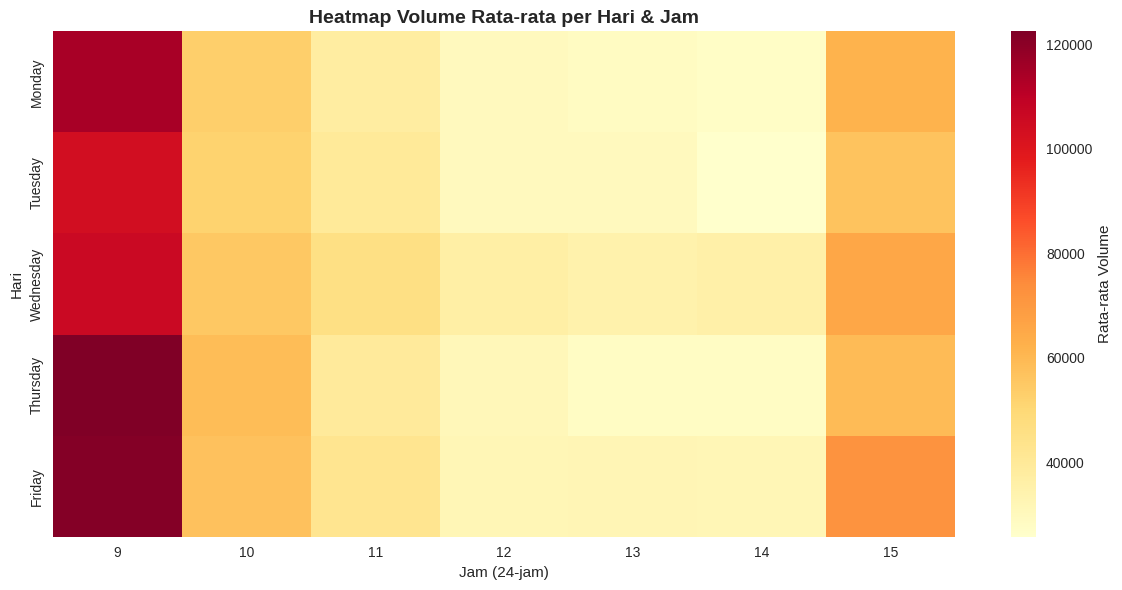

In [131]:
# 4. HEATMAP AKTIVITAS: HARI vs JAM
# Tujuan: Deteksi pola intraday dan weekly seasonality.
# Insight: Pasar paling aktif di pembukaan & penutupan; Senin/Jumat lebih volatile.
# ===================================================================
print("\n4.Heatmap Aktivitas Perdagangan (Hari vs Jam)")
print("-" * 40)
print("Menunjukkan jam dan hari dengan aktivitas perdagangan tertinggi.")

# Buat pivot: rata-rata volume per (hari, jam)
heatmap_data = df_final.groupby(['day_of_week', 'hour'])['volume'].mean().unstack(fill_value=0)

# Urutkan hari sesuai urutan kalender
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
heatmap_data = heatmap_data.reindex(day_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Rata-rata Volume'})
plt.title('Heatmap Volume Rata-rata per Hari & Jam', fontsize=14, fontweight='bold')
plt.xlabel('Jam (24-jam)')
plt.ylabel('Hari')
plt.tight_layout()
plt.show()


5. Distribusi Return Menit-an & Volatilitas Intraday
----------------------------------------
Return dan volatilitas adalah input kunci untuk model prediksi.


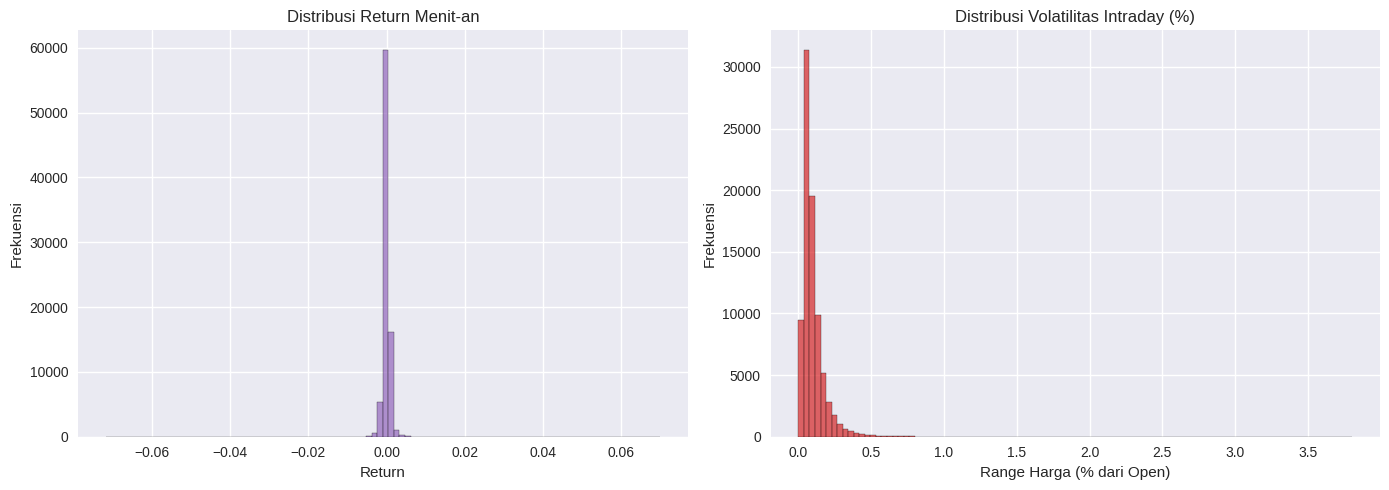

In [132]:
# ===================================================================
# 5. DISTRIBUSI RETURN & VOLATILITAS INTRADAY
# Tujuan: Analisis risiko dan pergerakan harga per menit.
# Insight: Return tidak normal (fat tails); volatilitas stabil.
# ===================================================================
print("\n5. Distribusi Return Menit-an & Volatilitas Intraday")
print("-" * 40)
print("Return dan volatilitas adalah input kunci untuk model prediksi.")

df_final['abs_return'] = df_final['return'].abs()
df_final['intraday_range_pct'] = (df_final['high'] - df_final['low']) / df_final['open'] * 100

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Return
ax[0].hist(df_final['return'].dropna(), bins=100, color='tab:purple', alpha=0.7, edgecolor='black')
ax[0].set_title('Distribusi Return Menit-an')
ax[0].set_xlabel('Return')
ax[0].set_ylabel('Frekuensi')

# Volatilitas
ax[1].hist(df_final['intraday_range_pct'], bins=100, color='tab:red', alpha=0.7, edgecolor='black')
ax[1].set_title('Distribusi Volatilitas Intraday (%)')
ax[1].set_xlabel('Range Harga (% dari Open)')
ax[1].set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [133]:
# ===================================================================
# 6. INSIGHT RINGKAS TAMBAHAN
# Tujuan: Sajikan ringkasan eksekutif untuk pengambilan keputusan.
# ===================================================================
print("\n7.Insight Ringkas Tambahan")
print("-" * 40)

avg_min_per_day = len(df_final) / df_final['date'].nunique()
print(f"Rata-rata menit/hari     : {avg_min_per_day:.1f} / 390 (ideal)")
print(f"Kelengkapan data         : {avg_min_per_day / 390 * 100:.1f}%")

max_vol_row = df_final.loc[df_final['volume'].idxmax()]
print(f"\nVolume tertinggi         : {max_vol_row['volume']:,.0f}")
print(f"                          pada {max_vol_row['timestamp']}")

price_change_pct = (df_final['close'].iloc[-1] - df_final['close'].iloc[0]) / df_final['close'].iloc[0] * 100
print(f"Perubahan harga total    : {price_change_pct:+.2f}%")


7.Insight Ringkas Tambahan
----------------------------------------
Rata-rata menit/hari     : 390.0 / 390 (ideal)
Kelengkapan data         : 100.0%

Volume tertinggi         : 4,282,263
                          pada 2025-06-20 09:30:00-04:00
Perubahan harga total    : +46.23%


# **Dataset CSV SnP 500**

In [134]:
# ============================================================
# 📈 ANALISIS EDA DATA S&P 500 (SnP_daily_update.csv, hanya 2025)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Memulai pipeline S&P500 daily dari SnP_daily_update.csv...\n")

Memulai pipeline S&P500 daily dari SnP_daily_update.csv...



In [135]:
# --------------------------
# 1. Baca file S&P500
# --------------------------
df_snp = pd.read_csv(
    "SnP_daily_update.csv",
    header=[0, 1],   # dua baris header
    index_col=0,
    skiprows=[2]     # lewati baris tambahan
)

# Reset index dan ubah ke format long
df_snp.index = pd.to_datetime(df_snp.index)
df_snp = df_snp.reset_index().rename(columns={'index': 'Date'})

df_long = df_snp.set_index('Date').stack([0, 1], future_stack=True).reset_index()
df_long.columns = ['Date', 'Price_Type', 'Ticker', 'Value']

# Pivot ke format wide (per ticker)
df_wide = df_long.pivot_table(
    index=['Date', 'Ticker'],
    columns='Price_Type',
    values='Value',
    aggfunc='first'
).reset_index()

df_wide.columns.name = None
df_wide.rename(columns={
    "Close": "close",
    "High": "high",
    "Low": "low",
    "Open": "open",
    "Volume": "volume"
}, inplace=True)

In [136]:
# --------------------------
# 2. Validasi awal
# --------------------------
print("📊 Cek kondisi awal sebelum cleaning")
total_rows = len(df_wide)
na_counts = df_wide[['close', 'open', 'high', 'low', 'volume']].isna().sum()
neg_or_zero = (df_wide[['close', 'open', 'high', 'low']] <= 0).sum()

print(f"- Total baris: {total_rows:,}")
print(f"- Jumlah NaN per kolom:\n{na_counts}")
print(f"- Jumlah harga ≤ 0 per kolom:\n{neg_or_zero}\n")

📊 Cek kondisi awal sebelum cleaning
- Total baris: 1,886,639
- Jumlah NaN per kolom:
close     0
open      0
high      0
low       0
volume    0
dtype: int64
- Jumlah harga ≤ 0 per kolom:
close    0
open     0
high     0
low      0
dtype: int64



In [137]:
# --------------------------
# 3. Cleaning sederhana
# --------------------------
df_wide_clean = df_wide.dropna(subset=['close', 'open', 'high', 'low', 'volume'])
df_wide_clean = df_wide_clean[(df_wide_clean[['close', 'open', 'high', 'low']] > 0).all(axis=1)]

print("✅ Setelah cleaning")
print(f"- Baris tersisa: {len(df_wide_clean):,}")

✅ Setelah cleaning
- Baris tersisa: 1,886,639


In [138]:
# --------------------------
# 4. Agregasi harian
# --------------------------
df_daily = df_wide_clean.groupby('Date').agg(
    sp500_avg_close=('close', 'mean')
).reset_index()

# Tambahkan fitur tambahan
df_daily['sp500_return'] = df_daily['sp500_avg_close'].pct_change().fillna(0)
df_daily['sp500_ma5'] = df_daily['sp500_avg_close'].rolling(5, min_periods=1).mean()
df_daily['sp500_ma20'] = df_daily['sp500_avg_close'].rolling(20, min_periods=1).mean()
df_daily['sp500_volatility'] = df_daily['sp500_return'].rolling(20, min_periods=1).std() * np.sqrt(252)

In [139]:
# --------------------------
# 5. Filter hanya tahun 2025
# --------------------------
df_daily['year'] = pd.to_datetime(df_daily['Date']).dt.year
df_daily_2025 = df_daily[df_daily['year'] == 2025].copy()

if df_daily_2025.empty:
    print("⚠️ Tidak ditemukan data untuk tahun 2025 — pastikan file SnP_daily_update.csv sudah update.")
else:
    print(f"\n✅ Data S&P500 difilter untuk tahun 2025: {len(df_daily_2025):,} baris\n")
    print(df_daily_2025.head())


✅ Data S&P500 difilter untuk tahun 2025: 213 baris

           Date  sp500_avg_close  sp500_return  sp500_ma5  sp500_ma20  \
3774 2025-01-02         213.7601       -0.0036   215.7557    220.9166   
3775 2025-01-03         215.9086        0.0101   215.1803    220.2363   
3776 2025-01-06         215.7890       -0.0006   214.9446    219.6219   
3777 2025-01-07         214.4701       -0.0061   214.8913    218.9141   
3778 2025-01-08         215.7044        0.0058   215.1264    218.3441   

      sp500_volatility  year  
3774            0.1376  2025  
3775            0.1451  2025  
3776            0.1448  2025  
3777            0.1440  2025  
3778            0.1467  2025  


In [140]:
# ============================================================
# 6. EDA VISUAL – Hanya tahun 2025
# ============================================================
sns.set_style("whitegrid")

# a. Ringkasan Statistik Dasar
print("1. Ringkasan Statistik Dasar (S&P500 daily 2025)")
print("-" * 50)
print(f"Total observasi     : {len(df_daily_2025):,}")
print(f"Rentang waktu       : {df_daily_2025['Date'].min()} → {df_daily_2025['Date'].max()}")
print(f"Hari perdagangan    : {df_daily_2025['Date'].nunique()}")
print("\nStatistik Close (Average S&P500):")
print(df_daily_2025[['sp500_avg_close']].describe().round(4))
print("-" * 50)

1. Ringkasan Statistik Dasar (S&P500 daily 2025)
--------------------------------------------------
Total observasi     : 213
Rentang waktu       : 2025-01-02 00:00:00 → 2025-11-06 00:00:00
Hari perdagangan    : 213

Statistik Close (Average S&P500):
       sp500_avg_close
count         213.0000
mean          220.5116
std             9.1108
min           188.1154
25%           215.5933
50%           221.6957
75%           227.8761
max           234.0498
--------------------------------------------------


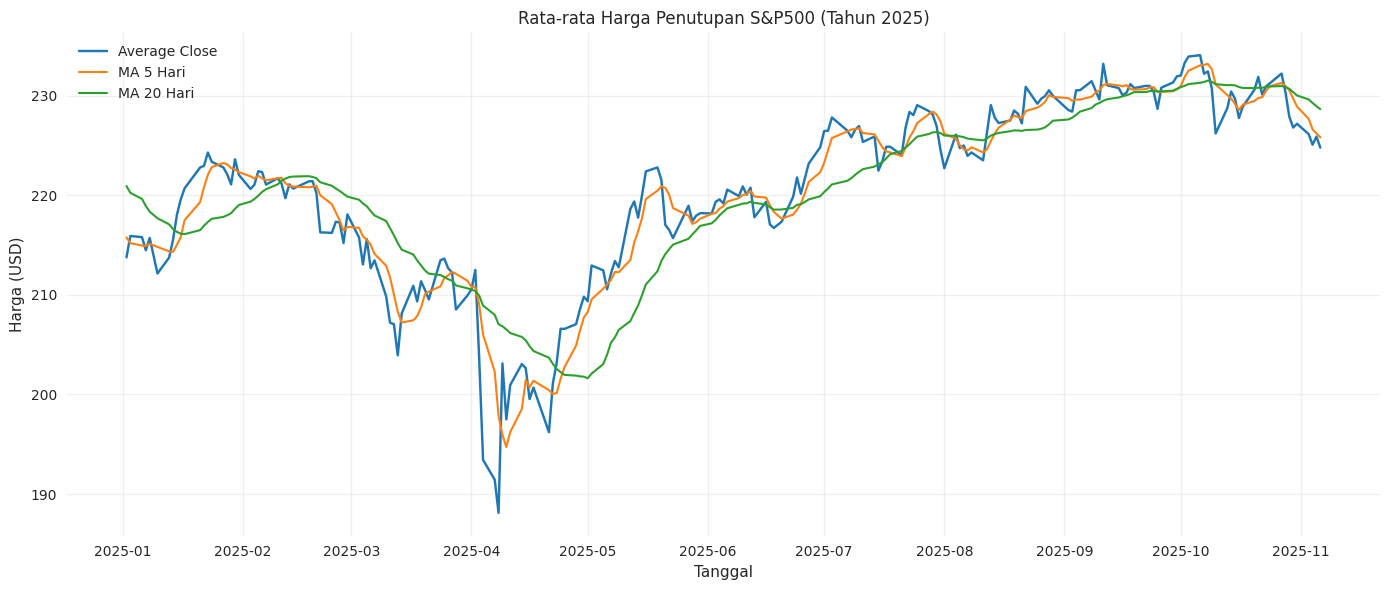

In [141]:
# b. Tren harga rata-rata
plt.figure(figsize=(14,6))
plt.plot(df_daily_2025['Date'], df_daily_2025['sp500_avg_close'], label='Average Close', color='tab:blue')
plt.plot(df_daily_2025['Date'], df_daily_2025['sp500_ma5'], label='MA 5 Hari', color='tab:orange', linewidth=1.5)
plt.plot(df_daily_2025['Date'], df_daily_2025['sp500_ma20'], label='MA 20 Hari', color='tab:green', linewidth=1.5)
plt.title('Rata-rata Harga Penutupan S&P500 (Tahun 2025)')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

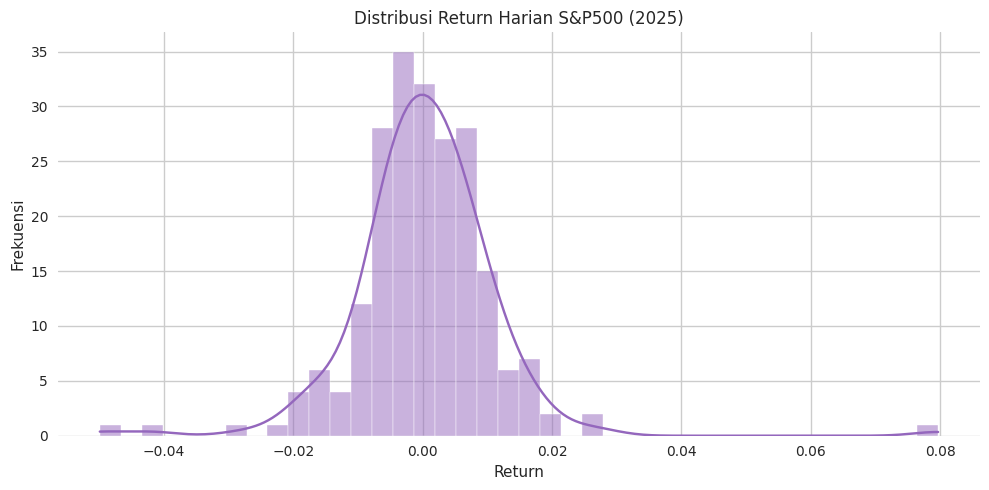

In [142]:
# c. Distribusi Return Harian
plt.figure(figsize=(10,5))
sns.histplot(df_daily_2025['sp500_return'], bins=40, kde=True, color='tab:purple')
plt.title('Distribusi Return Harian S&P500 (2025)')
plt.xlabel('Return')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

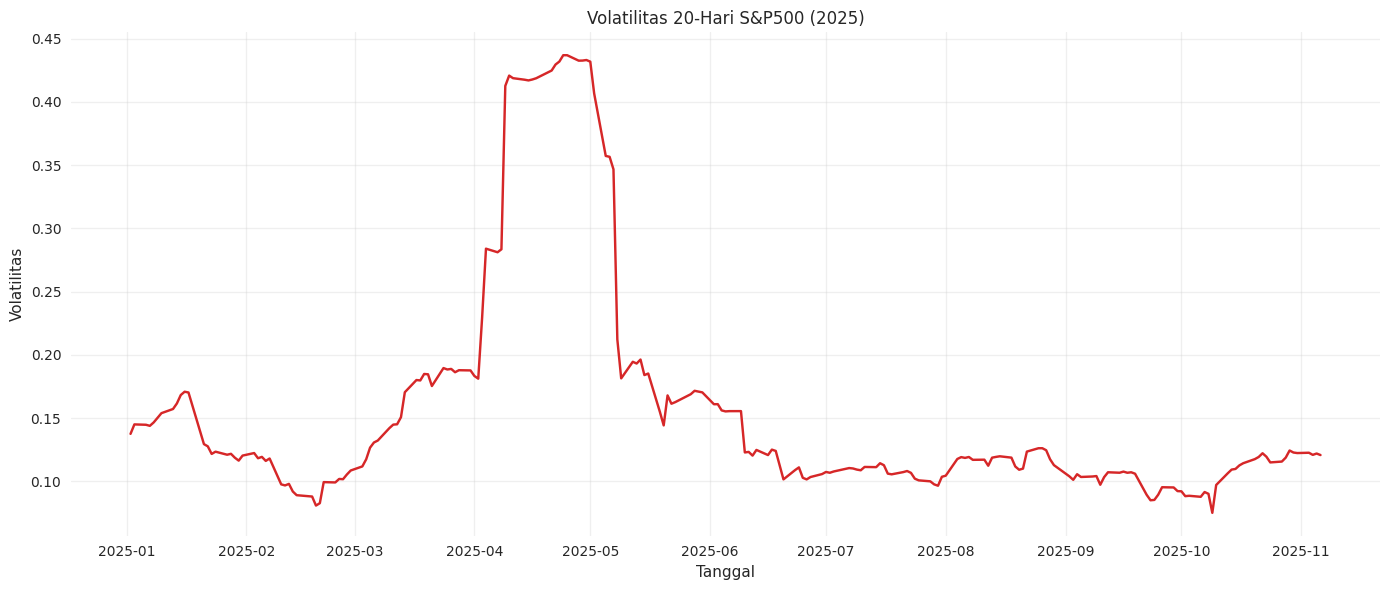

In [143]:
# d. Volatilitas 20 Hari
plt.figure(figsize=(14,6))
plt.plot(df_daily_2025['Date'], df_daily_2025['sp500_volatility'], color='tab:red')
plt.title('Volatilitas 20-Hari S&P500 (2025)')
plt.xlabel('Tanggal')
plt.ylabel('Volatilitas')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Korelasi antara Return dan Volatilitas (2025): 0.1132


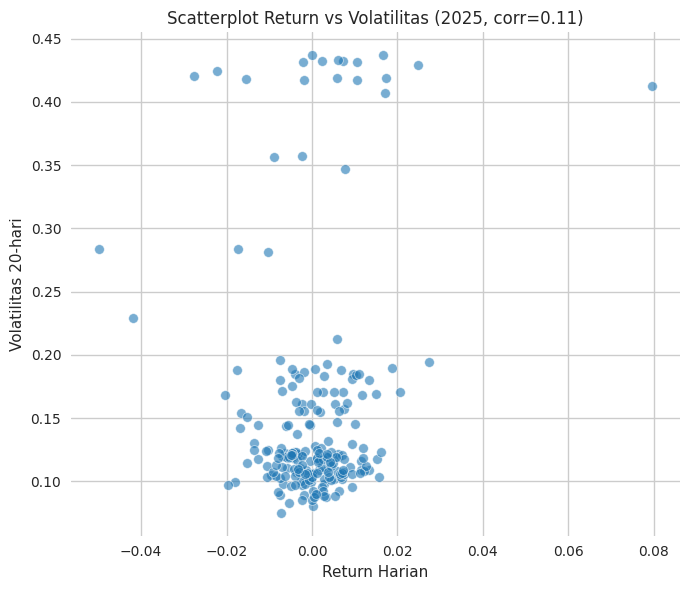

In [144]:
# e. Korelasi return vs volatilitas
corr = df_daily_2025[['sp500_return', 'sp500_volatility']].corr().iloc[0,1]
print(f"\nKorelasi antara Return dan Volatilitas (2025): {corr:.4f}")

plt.figure(figsize=(7,6))
sns.scatterplot(
    x='sp500_return', y='sp500_volatility',
    data=df_daily_2025, color='tab:blue', alpha=0.6
)
plt.title(f'Scatterplot Return vs Volatilitas (2025, corr={corr:.2f})')
plt.xlabel('Return Harian')
plt.ylabel('Volatilitas 20-hari')
plt.tight_layout()
plt.show()

In [145]:
# f. Insight ringkas
print("\n📋 INSIGHT RINGKAS (2025)")
print("-" * 50)
print(f"Total hari tercatat     : {len(df_daily_2025):,}")
print(f"Rentang waktu           : {df_daily_2025['Date'].min().date()} → {df_daily_2025['Date'].max().date()}")
print(f"Rata-rata harga penutupan: {df_daily_2025['sp500_avg_close'].mean():.2f}")
print(f"Return kumulatif        : {(df_daily_2025['sp500_avg_close'].iloc[-1] / df_daily_2025['sp500_avg_close'].iloc[0] - 1) * 100:.2f}%")
print(f"Rata-rata volatilitas   : {df_daily_2025['sp500_volatility'].mean():.4f}")
print("-" * 50)
print("✅ EDA selesai — hanya tahun 2025 digunakan, siap disinkronkan dengan dataset GOOG.")


📋 INSIGHT RINGKAS (2025)
--------------------------------------------------
Total hari tercatat     : 213
Rentang waktu           : 2025-01-02 → 2025-11-06
Rata-rata harga penutupan: 220.51
Return kumulatif        : 5.15%
Rata-rata volatilitas   : 0.1554
--------------------------------------------------
✅ EDA selesai — hanya tahun 2025 digunakan, siap disinkronkan dengan dataset GOOG.


# **Merged Data**

In [146]:
# ============================================================
# 📈 PIPELINE TERPADU: GOOG Minute Data (dataset.csv)
# + S&P500 Daily Data (SnP_daily_update.csv)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

print("🚀 Memulai pipeline sinkronisasi GOOG + S&P500 2025...\n")

🚀 Memulai pipeline sinkronisasi GOOG + S&P500 2025...



In [147]:
# ============================================================
# 1️⃣ BACA DATA GOOG MINUTE (dataset.csv)
# ============================================================
df_goog = pd.read_csv("dataset.csv")

print("📂 Preview kolom timestamp dari dataset.csv:")
print(df_goog['timestamp'].head(5))

# Parse sebagai datetime dengan dukungan timezone (gunakan utc=True untuk handle offset)
df_goog['timestamp'] = pd.to_datetime(df_goog['timestamp'], errors='coerce', utc=True)

# Sekarang pastikan semua waktu dalam US/Eastern
df_goog['timestamp'] = df_goog['timestamp'].dt.tz_convert('US/Eastern')

# Baru sekarang aman pakai .dt
df_goog['date'] = df_goog['timestamp'].dt.date
df_goog = df_goog.sort_values('timestamp')

# Filter tahun 2025
df_goog = df_goog[df_goog['timestamp'].dt.year == 2025]

print(f"✅ GOOG data dimuat: {len(df_goog):,} baris, rentang {df_goog['timestamp'].min()} → {df_goog['timestamp'].max()}")
print(f"Hari perdagangan unik: {df_goog['date'].nunique()}\n")

📂 Preview kolom timestamp dari dataset.csv:
0    2025-01-02 09:30:00-05:00
1    2025-01-02 09:31:00-05:00
2    2025-01-02 09:32:00-05:00
3    2025-01-02 09:33:00-05:00
4    2025-01-02 09:34:00-05:00
Name: timestamp, dtype: object
✅ GOOG data dimuat: 83,460 baris, rentang 2025-01-02 09:30:00-05:00 → 2025-11-07 15:59:00-05:00
Hari perdagangan unik: 214



In [148]:
# ============================================================
# 2️⃣ BACA DAN PROSES DATA S&P500
# ============================================================
df_snp = pd.read_csv(
    "SnP_daily_update.csv",
    header=[0, 1],
    index_col=0,
    skiprows=[2]
)

# Ubah ke format long
df_snp.index = pd.to_datetime(df_snp.index)
df_snp = df_snp.reset_index().rename(columns={'index': 'Date'})
df_long = df_snp.set_index('Date').stack([0,1], future_stack=True).reset_index()
df_long.columns = ['Date', 'Price_Type', 'Ticker', 'Value']

# Pivot agar setiap ticker 1 baris
df_wide = df_long.pivot_table(
    index=['Date', 'Ticker'],
    columns='Price_Type',
    values='Value',
    aggfunc='first'
).reset_index()

df_wide.columns.name = None
df_wide.rename(columns={
    "Close": "close",
    "High": "high",
    "Low": "low",
    "Open": "open",
    "Volume": "volume"
}, inplace=True)

# Cleaning sederhana
df_wide_clean = df_wide.dropna(subset=['close','open','high','low','volume'])
df_wide_clean = df_wide_clean[(df_wide_clean[['close','open','high','low']] > 0).all(axis=1)]

# Agregasi harian (rata-rata semua ticker)
df_daily = df_wide_clean.groupby('Date').agg(
    sp500_avg_close=('close','mean')
).reset_index()

# Fitur tambahan
df_daily['sp500_return'] = df_daily['sp500_avg_close'].pct_change().fillna(0)
df_daily['sp500_ma5'] = df_daily['sp500_avg_close'].rolling(5, min_periods=1).mean()
df_daily['sp500_ma20'] = df_daily['sp500_avg_close'].rolling(20, min_periods=1).mean()
df_daily['sp500_volatility'] = df_daily['sp500_return'].rolling(20, min_periods=1).std() * np.sqrt(252)

# Filter tahun 2025
df_daily['year'] = pd.to_datetime(df_daily['Date']).dt.year
df_snp_2025 = df_daily[df_daily['year'] == 2025].copy()

print(f"✅ S&P500 data difilter ke 2025: {len(df_snp_2025):,} baris\n")

✅ S&P500 data difilter ke 2025: 213 baris



In [149]:
# ============================================================
# 3️⃣ SINKRONISASI GOOG + S&P500 (berdasarkan date)
# ============================================================
df_snp_2025['date'] = pd.to_datetime(df_snp_2025['Date']).dt.date
df_merged = pd.merge(df_goog, df_snp_2025, on='date', how='left')

# Hapus baris tanpa match (jika hari libur S&P500)
df_merged = df_merged.dropna(subset=['sp500_avg_close'])

print(f"✅ Data gabungan siap: {len(df_merged):,} baris ({df_merged['date'].nunique()} hari)")
print(f"Kolom gabungan:\n{df_merged.columns.tolist()}\n")

✅ Data gabungan siap: 83,070 baris (213 hari)
Kolom gabungan:
['timestamp', 'close', 'high', 'low', 'open', 'volume', 'date', 'time_diff', 'Date', 'sp500_avg_close', 'sp500_return', 'sp500_ma5', 'sp500_ma20', 'sp500_volatility', 'year']



In [150]:
# ============================================================
# 4️⃣ EDA GABUNGAN
# ============================================================

# Korelasi harian antara GOOG dan S&P500
corr = df_merged[['close', 'sp500_avg_close']].corr().iloc[0,1]
print(f"📈 Korelasi antara harga GOOG dan rata-rata S&P500 (2025): {corr:.4f}")

📈 Korelasi antara harga GOOG dan rata-rata S&P500 (2025): 0.7514


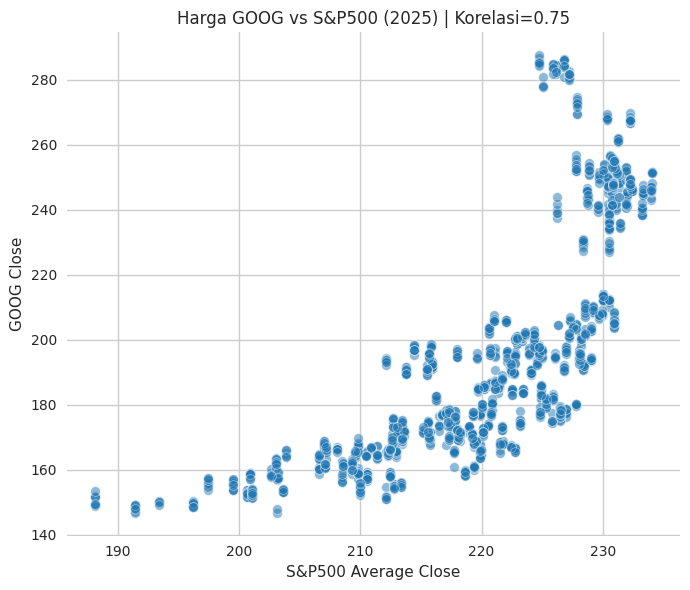

In [151]:
# Scatter plot
plt.figure(figsize=(7,6))
sns.scatterplot(
    x='sp500_avg_close', y='close',
    data=df_merged.sample(2000) if len(df_merged) > 2000 else df_merged,
    alpha=0.5, color='tab:blue'
)
plt.title(f'Harga GOOG vs S&P500 (2025) | Korelasi={corr:.2f}')
plt.xlabel('S&P500 Average Close')
plt.ylabel('GOOG Close')
plt.tight_layout()
plt.show()

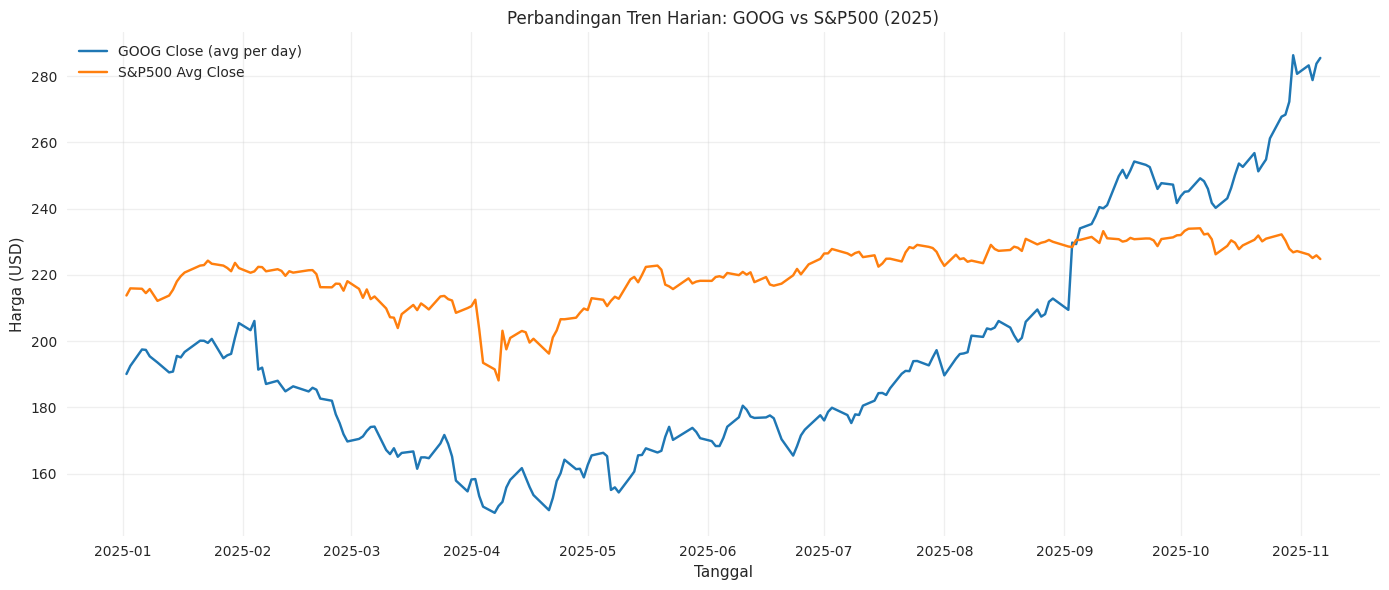

In [152]:
# Tren keduanya
plt.figure(figsize=(14,6))
plt.plot(df_merged.groupby('date')['close'].mean(), label='GOOG Close (avg per day)', color='tab:blue')
plt.plot(df_snp_2025.set_index('Date')['sp500_avg_close'], label='S&P500 Avg Close', color='tab:orange')
plt.title("Perbandingan Tren Harian: GOOG vs S&P500 (2025)")
plt.xlabel("Tanggal")
plt.ylabel("Harga (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [153]:
# ============================================================
# 5️⃣ SIMPAN HASIL MERGE
# ============================================================
df_merged.to_csv("merged_GOOG_SNP500_2025.csv", index=False)
print("\n💾 File 'merged_GOOG_SNP500_2025.csv' berhasil disimpan.")
print("Siap digunakan untuk modelling atau feature engineering berikutnya.")


💾 File 'merged_GOOG_SNP500_2025.csv' berhasil disimpan.
Siap digunakan untuk modelling atau feature engineering berikutnya.


# **Classification**

In [154]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import matplotlib.pyplot as plt

In [155]:
# ---------- CONFIG ----------
SEQ_LEN = 60
HORIZON = 120
THRESHOLD_PERCENTILE = 20
BATCH_SIZE = 64
EPOCHS = 30
LR = 5e-4
MERGED_PATH = "merged_GOOG_SNP500_2025.csv"

print("▶ Memulai Pipeline Perbandingan: LSTM vs XGBoost")

▶ Memulai Pipeline Perbandingan: LSTM vs XGBoost


In [156]:
# ---------- LOAD DATA ----------
if not os.path.exists(MERGED_PATH):
    raise SystemExit("File 'merged_GOOG_SNP500_2025.csv' tidak ditemukan.")

df_merged = pd.read_csv(MERGED_PATH)
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'], errors='coerce', utc=True)
df_merged = df_merged.dropna(subset=['timestamp']).reset_index(drop=True)
df_merged['timestamp'] = df_merged['timestamp'].dt.tz_convert('US/Eastern')
df_merged['date'] = df_merged['timestamp'].dt.tz_localize(None).dt.normalize()

df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['minute'] = df_merged['timestamp'].dt.minute
df_merged = df_merged[
    ((df_merged['hour'] == 9) & (df_merged['minute'] >= 30)) |
    ((df_merged['hour'] > 9) & (df_merged['hour'] < 16))
].reset_index(drop=True)

print(f"✅ Data dalam jam perdagangan: {len(df_merged):,} baris")

✅ Data dalam jam perdagangan: 83,070 baris


In [157]:
# ---------- 2) FEATURE ENGINEERING ----------
df = df_merged.copy().sort_values('timestamp').reset_index(drop=True)

df['future_close'] = df['close'].shift(-HORIZON)
df['return_horizon'] = (df['future_close'] - df['close']) / (df['close'] + 1e-12)
df['abs_return_horizon'] = df['return_horizon'].abs()
threshold = df['abs_return_horizon'].quantile(THRESHOLD_PERCENTILE / 100.0)
df['target'] = np.where(df['abs_return_horizon'] >= threshold, (df['return_horizon'] > 0).astype(int), np.nan)

df['return_30'] = df['close'].pct_change(30)
df['vol_ma_60'] = df['volume'].rolling(window=60, min_periods=1).mean()
df['vol_ratio'] = df['volume'] / (df['vol_ma_60'] + 1e-8)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / (loss + 1e-8)
    return 100 - (100 / (1 + rs))

df['rsi'] = compute_rsi(df['close'])

features = ['close', 'volume', 'return_30', 'vol_ratio', 'rsi']
df_model = df[features + ['target', 'timestamp', 'date']].dropna().reset_index(drop=True)
print(f"✅ Data siap untuk modelling: {len(df_model):,} baris")

✅ Data siap untuk modelling: 66,333 baris


In [158]:
# =============================================
# 🔹 TANGGAL SPLIT — KONSISTEN UNTUK KEDUA MODEL
# =============================================
train_end = pd.Timestamp('2025-08-31')
val_end = pd.Timestamp('2025-09-30')

In [159]:
# =============================================
# 🔹 PART A: XGBOOST — FLAT FEATURES
# =============================================
print("\n▶ MEMPROSES DATA UNTUK XGBOOST...")

train_mask_xgb = df_model['date'] <= train_end
val_mask_xgb = (df_model['date'] > train_end) & (df_model['date'] <= val_end)
test_mask_xgb = df_model['date'] > val_end

df_train_xgb = df_model[train_mask_xgb]
df_val_xgb = df_model[val_mask_xgb]
df_test_xgb = df_model[test_mask_xgb]

scaler_xgb = StandardScaler()
X_train_xgb = scaler_xgb.fit_transform(df_train_xgb[features])
X_val_xgb = scaler_xgb.transform(df_val_xgb[features])
X_test_xgb = scaler_xgb.transform(df_test_xgb[features])

y_train_xgb = df_train_xgb['target'].values.astype(int)
y_val_xgb = df_val_xgb['target'].values.astype(int)
y_test_xgb = df_test_xgb['target'].values.astype(int)

print(f"XGBoost Split — Train: {len(X_train_xgb)}, Val: {len(X_val_xgb)}, Test: {len(X_test_xgb)}")


▶ MEMPROSES DATA UNTUK XGBOOST...
XGBoost Split — Train: 51129, Val: 6813, Test: 8391


In [160]:
# Train XGBoost
sample_weights_xgb = compute_sample_weight('balanced', y_train_xgb)
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    early_stopping_rounds=10,
    use_label_encoder=False,
    random_state=42
)

print("\n▶ Melatih XGBoost...")
xgb_model.fit(
    X_train_xgb, y_train_xgb,
    sample_weight=sample_weights_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=0
)

y_pred_xgb = xgb_model.predict(X_test_xgb)


▶ Melatih XGBoost...


In [161]:
# =============================================
# 🔸 PART B: LSTM — SEQUENTIAL FEATURES
# =============================================
print("\n▶ MEMBANGUN SEKUENS UNTUK LSTM...")

X_list, y_list, ts_list = [], [], []
unique_dates = sorted(df_model['date'].unique())

for d in unique_dates:
    day_df = df_model[df_model['date'] == d].reset_index(drop=True)
    if len(day_df) < SEQ_LEN + HORIZON + 1:
        continue
    scaler = StandardScaler()
    scaled = scaler.fit_transform(day_df[features])
    labels = day_df['target'].values
    ts = day_df['timestamp'].values
    last_i = len(day_df) - HORIZON
    for i in range(SEQ_LEN, last_i):
        if np.isnan(labels[i]):
            continue
        X_list.append(scaled[i-SEQ_LEN:i])
        y_list.append(int(labels[i]))
        ts_list.append(ts[i])

X = np.array(X_list)
y = np.array(y_list)
timestamps = np.array(ts_list)
print(f"✅ Total sekuens LSTM: {X.shape[0]}")

df_seq = pd.DataFrame({
    'timestamp': timestamps,
    'date': pd.to_datetime(timestamps).date
})
df_seq['y'] = y

train_mask_lstm = df_seq['date'] <= train_end.date()
val_mask_lstm = (df_seq['date'] > train_end.date()) & (df_seq['date'] <= val_end.date())
test_mask_lstm = df_seq['date'] > val_end.date()

X_train_lstm, y_train_lstm = X[train_mask_lstm], y[train_mask_lstm]
X_val_lstm, y_val_lstm = X[val_mask_lstm], y[val_mask_lstm]
X_test_lstm, y_test_lstm = X[test_mask_lstm], y[test_mask_lstm]

print(f"LSTM Split — Train: {X_train_lstm.shape[0]}, Val: {X_val_lstm.shape[0]}, Test: {X_test_lstm.shape[0]}")


▶ MEMBANGUN SEKUENS UNTUK LSTM...
✅ Total sekuens LSTM: 27998
LSTM Split — Train: 21434, Val: 3033, Test: 3531



▶ Melatih LSTM...
Epoch 1/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.7182 - loss: 0.5606 - val_accuracy: 0.8404 - val_loss: 0.3469
Epoch 2/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.8249 - loss: 0.3992 - val_accuracy: 0.8516 - val_loss: 0.3331
Epoch 3/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8512 - loss: 0.3622 - val_accuracy: 0.8384 - val_loss: 0.3496
Epoch 4/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.8603 - loss: 0.3314 - val_accuracy: 0.8813 - val_loss: 0.3322
Epoch 5/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.8726 - loss: 0.3035 - val_accuracy: 0.8731 - val_loss: 0.3341
Epoch 6/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.8770 - loss: 0.3066 - val_accuracy: 0.8579 - val_loss: 0.3481
Epoch 7/30
335/335 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.8850 - loss: 0.2833 - val_accuracy: 0.8467 - val_loss: 0.3356


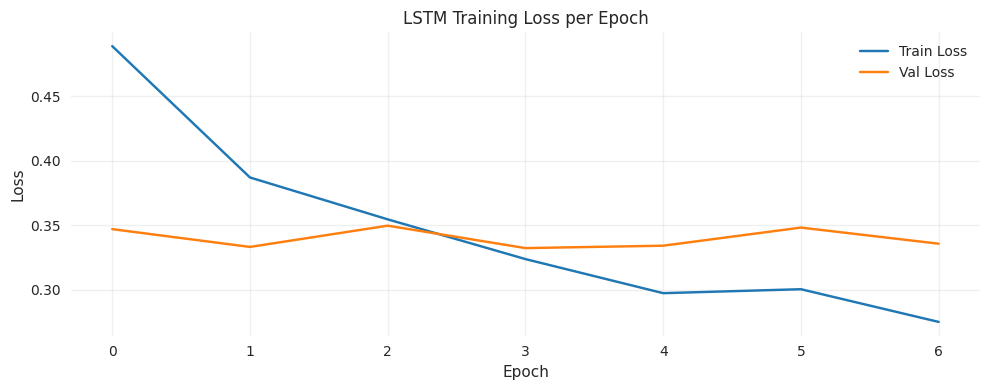

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [162]:
# Train LSTM
classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_lstm)
class_weight_dict = dict(zip(classes, class_weights))

tf.random.set_seed(42)
lstm_model = Sequential([
    LSTM(32, return_sequences=True, kernel_regularizer=l2(1e-4), input_shape=(SEQ_LEN, X.shape[2])),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(16, return_sequences=False, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(8, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

print("\n▶ Melatih LSTM...")
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history (loss per epoch)
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

y_prob_lstm = lstm_model.predict(X_test_lstm, batch_size=256).flatten()
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

In [163]:
# =============================================
# PERBANDINGAN HASIL — DENGAN CONFUSION MATRIX
# =============================================
print("\n" + "="*80)
print("📊 PERBANDINGAN AKHIR: XGBOOST vs LSTM — TEST SET (Okt–Nov 2025)")
print("="*80)

print("\n[1] XGBOOST Classification Report:")
print(classification_report(y_test_xgb, y_pred_xgb, target_names=['Down', 'Up']))

print("\n[2] LSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=['Down', 'Up']))


📊 PERBANDINGAN AKHIR: XGBOOST vs LSTM — TEST SET (Okt–Nov 2025)

[1] XGBOOST Classification Report:
              precision    recall  f1-score   support

        Down       0.41      0.01      0.02      3210
          Up       0.62      0.99      0.76      5181

    accuracy                           0.62      8391
   macro avg       0.51      0.50      0.39      8391
weighted avg       0.54      0.62      0.48      8391


[2] LSTM Classification Report:
              precision    recall  f1-score   support

        Down       0.73      0.86      0.79      1242
          Up       0.91      0.83      0.87      2289

    accuracy                           0.84      3531
   macro avg       0.82      0.84      0.83      3531
weighted avg       0.85      0.84      0.84      3531



Text(0.5, 1.0, 'Confusion Matrix — XGBoost')

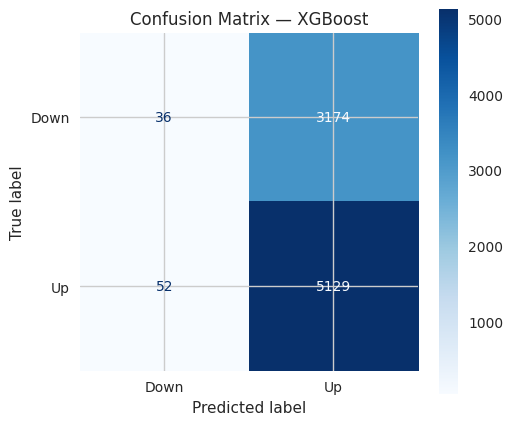

In [164]:
# --- Confusion Matrix XGBoost ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Down', 'Up'])
disp_xgb.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix — XGBoost')

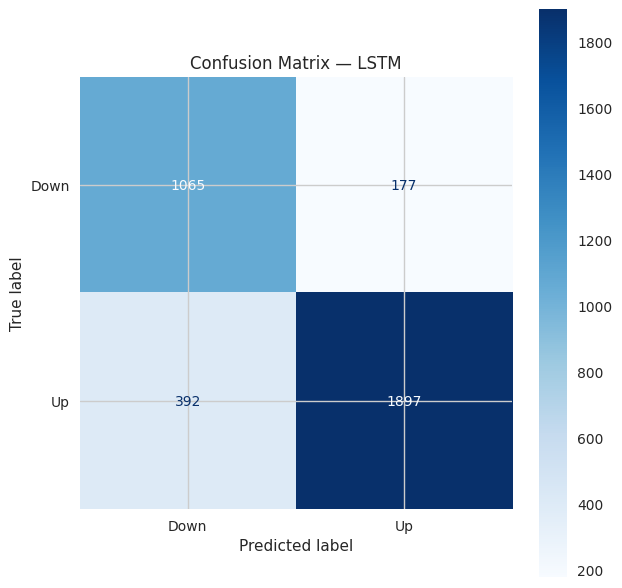

In [165]:
# --- Confusion Matrix LSTM ---
plt.subplot(1, 2, 2)
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['Down', 'Up'])
disp_lstm.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix — LSTM')

plt.tight_layout()
plt.show()

# **Regression**

In [166]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [167]:
# ---------- CONFIG ----------
SEQ_LEN = 60
HORIZON = 120
BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-3
MERGED_PATH = "merged_GOOG_SNP500_2025.csv"

print("▶ Starting Comparison: LSTM vs Linear Regression")

▶ Starting Comparison: LSTM vs Linear Regression


In [168]:
# ---------- 1) LOAD DATA ----------
if os.path.exists(MERGED_PATH):
    print(f"Loading merged file: {MERGED_PATH}")
    df_merged = pd.read_csv(MERGED_PATH)
else:
    raise SystemExit("Merged file not found.")

Loading merged file: merged_GOOG_SNP500_2025.csv


In [169]:
# ---------- 2) FIX TIMEZONE ----------
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'], errors='coerce', utc=True)
df_merged = df_merged.dropna(subset=['timestamp']).reset_index(drop=True)
df_merged['timestamp'] = df_merged['timestamp'].dt.tz_convert('US/Eastern')
df_merged['date'] = df_merged['timestamp'].dt.tz_convert(None).dt.normalize()

In [170]:
# ---------- 3) FILTER JAM PERDAGANGAN ----------
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['minute'] = df_merged['timestamp'].dt.minute
df_merged = df_merged[
    ((df_merged['hour'] > 9) | ((df_merged['hour'] == 9) & (df_merged['minute'] >= 30))) &
    (df_merged['hour'] < 16)
].reset_index(drop=True)
print(f"Filtered trading hours only: {len(df_merged):,} rows remain.")

Filtered trading hours only: 83,070 rows remain.


In [171]:
# ---------- 4) FEATURE ENGINEERING ----------
df = df_merged.copy()
df['future_close'] = df['close'].shift(-HORIZON)
df['return_horizon'] = (df['future_close'] - df['close']) / (df['close'] + 1e-12)

df['return_5'] = df['close'].pct_change(5)
df['return_30'] = df['close'].pct_change(30)
df['return_60'] = df['close'].pct_change(60)
df['vol_ma_60'] = df['volume'].rolling(window=60, min_periods=1).mean()
df['vol_ratio'] = df['volume'] / (df['vol_ma_60'] + 1e-8)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / (loss + 1e-8)
    return 100 - (100 / (1 + rs))

df['rsi'] = compute_rsi(df['close'])
df['candle'] = (df['close'] - df['open']) / (df['open'] + 1e-12)
df['bar_range'] = (df['high'] - df['low']) / (df['open'] + 1e-12)
df['volatility_30'] = df['return_30'].rolling(30).std()

features = [
    'close', 'volume', 'return_5', 'return_30', 'return_60',
    'vol_ratio', 'rsi', 'candle', 'bar_range', 'volatility_30',
    'sp500_avg_close', 'sp500_return', 'sp500_ma5', 'sp500_ma20', 'sp500_volatility'
]
available_features = [f for f in features if f in df.columns]

df_model = df[available_features + ['return_horizon', 'timestamp', 'date']].dropna().sort_values('timestamp').reset_index(drop=True)
print(f"Rows available for modelling: {len(df_model):,}")

Rows available for modelling: 82,890


In [172]:
# ---------- 5) BUILD SEQUENCES UNTUK LSTM ----------
X_lstm_list, y_lstm_list, ts_lstm_list = [], [], []
unique_dates = df_model['date'].unique()

for d in unique_dates:
    day_df = df_model[df_model['date'] == d].reset_index(drop=True)
    if len(day_df) < SEQ_LEN + 1 + HORIZON:
        continue
    scaler = StandardScaler()
    scaled = scaler.fit_transform(day_df[available_features])
    labels = day_df['return_horizon'].values
    ts = day_df['timestamp'].values
    last_i = len(day_df) - HORIZON
    for i in range(SEQ_LEN, last_i):
        X_lstm_list.append(scaled[i-SEQ_LEN:i])
        y_lstm_list.append(labels[i])
        ts_lstm_list.append(ts[i])

X_lstm = np.array(X_lstm_list, dtype=np.float32)
y_lstm = np.array(y_lstm_list, dtype=np.float32)
timestamps_lstm = np.array(ts_lstm_list)

print(f"Total LSTM sequences: {X_lstm.shape[0]} | X shape: {X_lstm.shape}")

Total LSTM sequences: 44550 | X shape: (44550, 60, 15)


In [173]:
# ---------- 6) SIAPKAN DATA UNTUK LINEAR REGRESSION ----------
X_lin_list, y_lin_list, ts_lin_list = [], [], []

for d in unique_dates:
    day_df = df_model[df_model['date'] == d].reset_index(drop=True)
    if len(day_df) < SEQ_LEN + 1 + HORIZON:
        continue
    # Ambil hanya fitur dari titik waktu "i-1"
    last_i = len(day_df) - HORIZON
    for i in range(SEQ_LEN, last_i):
        X_lin_list.append(day_df[available_features].iloc[i-1].values)
        y_lin_list.append(day_df['return_horizon'].iloc[i])
        ts_lin_list.append(day_df['timestamp'].iloc[i])

X_lin = np.array(X_lin_list, dtype=np.float32)
y_lin = np.array(y_lin_list, dtype=np.float32)
timestamps_lin = np.array(ts_lin_list)

In [174]:
# ---------- 7) SPLIT DATA (KONSISTEN) ----------
split_idx_lstm = int(len(X_lstm) * 0.8)
split_idx_lin = int(len(X_lin) * 0.8)

X_lstm_train, X_lstm_test = X_lstm[:split_idx_lstm], X_lstm[split_idx_lstm:]
y_lstm_train, y_lstm_test = y_lstm[:split_idx_lstm], y_lstm[split_idx_lstm:]

X_lin_train, X_lin_test = X_lin[:split_idx_lin], X_lin[split_idx_lin:]
y_lin_train, y_lin_test = y_lin[:split_idx_lin], y_lin[split_idx_lin:]

In [175]:
# ---------- 8) TRAIN LINEAR REGRESSION ----------
scaler_lin = StandardScaler()
X_lin_train_scaled = scaler_lin.fit_transform(X_lin_train)
X_lin_test_scaled = scaler_lin.transform(X_lin_test)

lin_reg = LinearRegression()
lin_reg.fit(X_lin_train_scaled, y_lin_train)

LinearRegression()

Epoch 1/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - loss: 0.0011 - mae: 0.0162 - val_loss: 2.1921e-05 - val_mae: 0.0036
Epoch 2/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 79s 74ms/step - loss: 4.7702e-05 - mae: 0.0043 - val_loss: 1.9362e-05 - val_mae: 0.0033
Epoch 3/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 83s 77ms/step - loss: 4.1559e-05 - mae: 0.0040 - val_loss: 1.8570e-05 - val_mae: 0.0033
Epoch 4/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - loss: 3.8319e-05 - mae: 0.0039 - val_loss: 1.9875e-05 - val_mae: 0.0034
Epoch 5/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - loss: 3.8220e-05 - mae: 0.0039 - val_loss: 2.0011e-05 - val_mae: 0.0034
Epoch 6/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - loss: 3.4262e-05 - mae: 0.0038 - val_loss: 2.0939e-05 - val_mae: 0.0035
Epoch 7/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - loss: 2.9502e-05 - mae: 0.0037 - val_loss: 2.4436e-05 - val_mae: 0.0036
Epoch 8/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - loss: 2.8346e-05 - mae: 0.0037 - val_loss: 1.9934e-0

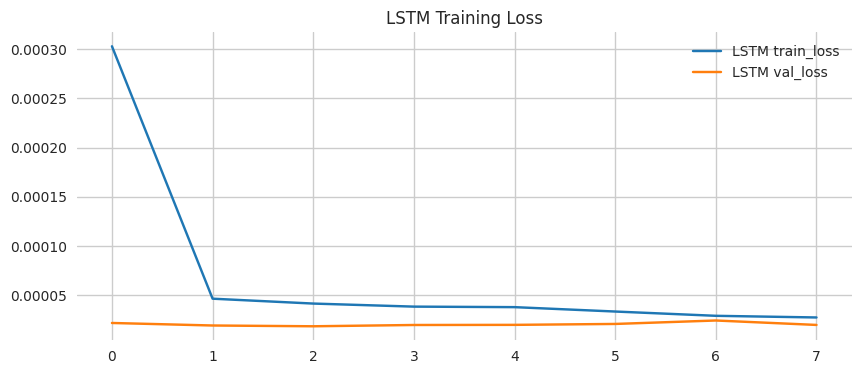

In [176]:
# ---------- 9) TRAIN LSTM REGRESSION ----------
tf.random.set_seed(42)
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X_lstm.shape[2])),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])
lstm_model.compile(optimizer=Adam(learning_rate=LR), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
history = lstm_model.fit(
    X_lstm_train, y_lstm_train,
    validation_data=(X_lstm_test, y_lstm_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='LSTM train_loss')
plt.plot(history.history['val_loss'], label='LSTM val_loss')
plt.title('LSTM Training Loss')
plt.legend()
plt.show()

In [177]:
# ---------- 10) EVALUASI KEDUA MODEL ----------
# Linear Regression
y_lin_pred = lin_reg.predict(X_lin_test_scaled)
mse_lin = mean_squared_error(y_lin_test, y_lin_pred)
rmse_lin = np.sqrt(mse_lin)
r2_lin = r2_score(y_lin_test, y_lin_pred)

# LSTM Regression
y_lstm_pred = lstm_model.predict(X_lstm_test, batch_size=256).flatten()
mse_lstm = mean_squared_error(y_lstm_test, y_lstm_pred)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_lstm_test, y_lstm_pred)

print("\n📊 PERBANDINGAN EVALUASI REGRESI (Return 120 Menit)")
print("=" * 60)
print(f"{'Model':<20} {'MSE':<12} {'RMSE':<10} {'R²':<8}")
print("-" * 60)
print(f"{'Linear Regression':<20} {mse_lin:<12.8f} {rmse_lin:<10.6f} {r2_lin:<8.4f}")
print(f"{'LSTM Regression':<20} {mse_lstm:<12.8f} {rmse_lstm:<10.6f} {r2_lstm:<8.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step

📊 PERBANDINGAN EVALUASI REGRESI (Return 120 Menit)
Model                MSE          RMSE       R²      
------------------------------------------------------------
Linear Regression    0.00003954   0.006288   -0.1422 
LSTM Regression      0.00001857   0.004309   0.4635  


In [178]:
# ---------- 11) PREDIKSI DARI DATA TERAKHIR ----------
last_day = df[df['date'] == df['date'].max()].reset_index(drop=True)
if len(last_day) < SEQ_LEN:
    raise ValueError("Tidak cukup data di hari terakhir.")

# Prediksi LSTM
scaler_last = StandardScaler()
scaled_last = scaler_last.fit_transform(last_day[available_features].iloc[-SEQ_LEN:])
X_last_lstm = scaled_last.reshape(1, SEQ_LEN, -1)
pred_lstm = lstm_model.predict(X_last_lstm, verbose=0)[0, 0]

# Prediksi Linear
X_last_lin = scaler_lin.transform(last_day[available_features].iloc[[-1]])
pred_lin = lin_reg.predict(X_last_lin)[0]

last_close = df['close'].iloc[-1]
last_ts = df['timestamp'].iloc[-1]

print(f"\n📌 Harga terakhir: ${last_close:.2f}")
print(f"📌 Prediksi Linear Regression (2 jam): {pred_lin*100:+.3f}%")
print(f"📌 Prediksi LSTM Regression (2 jam)   : {pred_lstm*100:+.3f}%")

# Hitung volatilitas per menit untuk kedua model
vol_per_min_lstm = abs(pred_lstm) / HORIZON
vol_per_min_lin = abs(pred_lin) / HORIZON


📌 Harga terakhir: $285.37
📌 Prediksi Linear Regression (2 jam): -0.961%
📌 Prediksi LSTM Regression (2 jam)   : +0.463%


In [179]:
# ---------- 12) BANGUN TIMELINE 120 MENIT KE DEPAN ----------
current_time = last_ts
future_times = []
for minute in range(1, HORIZON + 1):
    candidate = current_time + pd.Timedelta(minutes=1)
    while True:
        if candidate.weekday() >= 5:
            candidate = candidate.replace(hour=9, minute=30, second=0, microsecond=0)
            candidate += pd.Timedelta(days=1)
            continue
        if candidate.hour < 9 or (candidate.hour == 9 and candidate.minute < 30) or candidate.hour >= 16:
            candidate = candidate.replace(hour=9, minute=30, second=0, microsecond=0)
            candidate += pd.Timedelta(days=1)
            continue
        break
    future_times.append(candidate)
    current_time = candidate

In [180]:
# ---------- 13) HITUNG RENTANG HARGA UNTUK KEDUA MODEL ----------
future_prices_upper_lstm = []
future_prices_lower_lstm = []
future_prices_upper_lin = []
future_prices_lower_lin = []

for i in range(HORIZON):
    total_vol_lstm = vol_per_min_lstm * (i + 1)
    total_vol_lin = vol_per_min_lin * (i + 1)
    future_prices_upper_lstm.append(last_close * (1 + total_vol_lstm))
    future_prices_lower_lstm.append(last_close * (1 - total_vol_lstm))
    future_prices_upper_lin.append(last_close * (1 + total_vol_lin))
    future_prices_lower_lin.append(last_close * (1 - total_vol_lin))

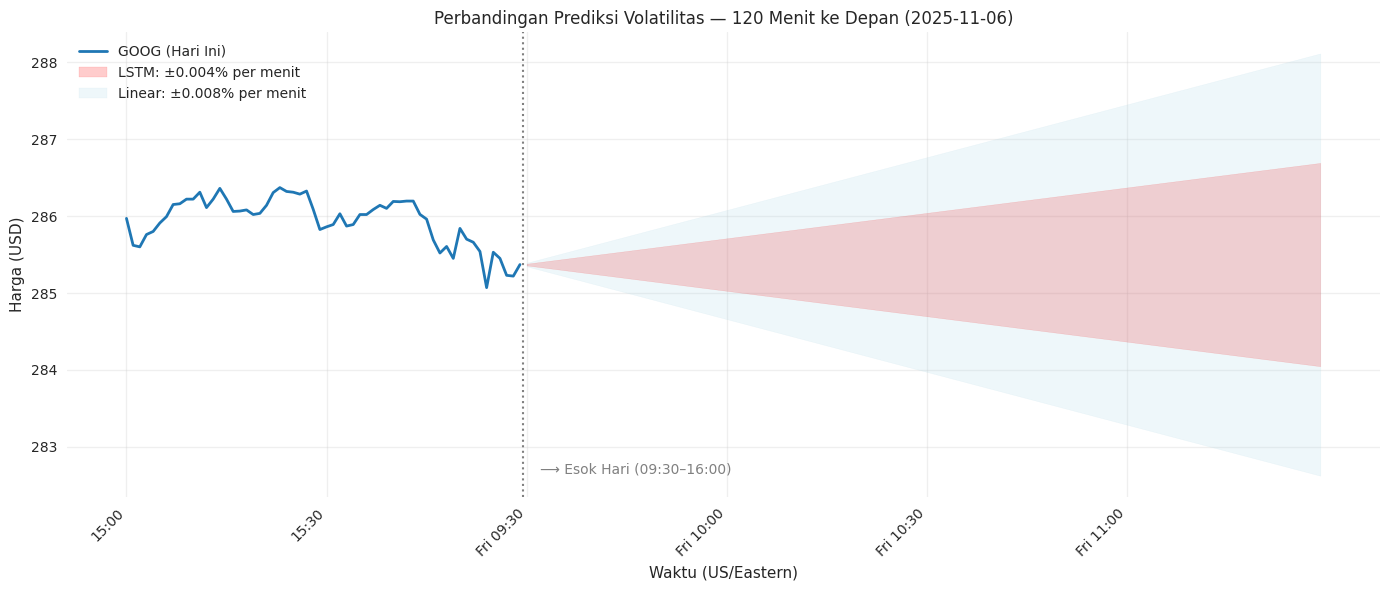

In [181]:
# ---------- 14) VISUALISASI PERBANDINGAN VOLATILITAS ----------
last_hour_data = df[
    (df['timestamp'].dt.date == last_ts.date()) &
    (df['timestamp'].dt.hour >= 15)
]

combined_times = list(last_hour_data['timestamp']) + future_times
upper_band_lstm = list(last_hour_data['close']) + future_prices_upper_lstm
lower_band_lstm = list(last_hour_data['close']) + future_prices_lower_lstm
upper_band_lin = list(last_hour_data['close']) + future_prices_upper_lin
lower_band_lin = list(last_hour_data['close']) + future_prices_lower_lin

x_vals = np.arange(len(combined_times))

plt.figure(figsize=(14, 6))
plt.plot(x_vals[:len(last_hour_data)], last_hour_data['close'],
         color='tab:blue', linewidth=2, label='GOOG (Hari Ini)')
plt.fill_between(
    x_vals[len(last_hour_data):],
    lower_band_lstm[len(last_hour_data):],
    upper_band_lstm[len(last_hour_data):],
    color='red', alpha=0.2,
    label=f'LSTM: ±{vol_per_min_lstm*100:.3f}% per menit'
)
plt.fill_between(
    x_vals[len(last_hour_data):],
    lower_band_lin[len(last_hour_data):],
    upper_band_lin[len(last_hour_data):],
    color='lightblue', alpha=0.2,
    label=f'Linear: ±{vol_per_min_lin*100:.3f}% per menit'
)
sep_idx = len(last_hour_data)
plt.axvline(sep_idx - 0.5, color='gray', linestyle=':', linewidth=1.5)
plt.text(sep_idx + 2, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05,
         '⟶ Esok Hari (09:30–16:00)', color='gray', fontsize=10)

x_ticks, x_labels = [], []
for i, ts in enumerate(combined_times):
    if i < len(last_hour_data):
        if ts.minute % 30 == 0:
            x_ticks.append(i); x_labels.append(ts.strftime('%H:%M'))
    else:
        if (i - len(last_hour_data)) % 30 == 0:
            x_ticks.append(i); x_labels.append(ts.strftime('%a %H:%M'))

plt.xticks(x_ticks, x_labels, rotation=45, ha='right')
plt.title(f'Perbandingan Prediksi Volatilitas — 120 Menit ke Depan ({last_ts.date()})')
plt.xlabel('Waktu (US/Eastern)')
plt.ylabel('Harga (USD)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [182]:
# ---------- 15) TAMPILKAN CONTOH TITIK ----------
print(f"\n📋 Contoh Titik Volatilitas:")
print(f"Menit 1  ({future_times[0]}):")
print(f"  LSTM: ${future_prices_lower_lstm[0]:.2f} – ${future_prices_upper_lstm[0]:.2f}")
print(f"  Linear: ${future_prices_lower_lin[0]:.2f} – ${future_prices_upper_lin[0]:.2f}")
print(f"Menit 120 ({future_times[-1]}):")
print(f"  LSTM: ${future_prices_lower_lstm[-1]:.2f} – ${future_prices_upper_lstm[-1]:.2f}")
print(f"  Linear: ${future_prices_lower_lin[-1]:.2f} – ${future_prices_upper_lin[-1]:.2f}")

# ---------- 16) SIMPAN MODEL ----------
lstm_model.save("lstm_goog_sp500_regression.h5")
print("\n✅ Model LSTM disimpan sebagai 'lstm_goog_sp500_regression.h5'")


📋 Contoh Titik Volatilitas:
Menit 1  (2025-11-07 09:30:00-05:00):
  LSTM: $285.36 – $285.38
  Linear: $285.35 – $285.39
Menit 120 (2025-11-07 11:29:00-05:00):
  LSTM: $284.05 – $286.69
  Linear: $282.63 – $288.11

✅ Model LSTM disimpan sebagai 'lstm_goog_sp500_regression.h5'


# **Clustering**

In [6]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# -----------------------------
# 1. LOAD & FILTER DATA
# -----------------------------
df_cluster = pd.read_csv("merged_GOOG_SNP500_2025.csv")
df_cluster['timestamp'] = pd.to_datetime(df_cluster['timestamp'], utc=True)
df_cluster['timestamp'] = df_cluster['timestamp'].dt.tz_convert('US/Eastern')

df_cluster = df_cluster[
    ((df_cluster['timestamp'].dt.hour == 9) & (df_cluster['timestamp'].dt.minute >= 30)) |
    ((df_cluster['timestamp'].dt.hour > 9) & (df_cluster['timestamp'].dt.hour < 16))
].copy()

In [8]:
# -----------------------------
# 2. RESAMPLE KE 15 MENIT
# -----------------------------
df_cluster = df_cluster.set_index('timestamp')
df_15min = df_cluster.resample('15T').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'sp500_avg_close': 'last'
}).dropna()
df_cluster = df_15min.reset_index()

In [9]:
# -----------------------------
# 3. FEATURE ENGINEERING
# -----------------------------
df_cluster['return_15'] = df_cluster['close'].pct_change(1)
df_cluster['rsi'] = df_cluster['close'].rolling(14).apply(
    lambda x: 100 - (100 / (1 + (
        (x.diff().clip(lower=0).mean() + 1e-8) /
        (-x.diff().clip(upper=0).mean() + 1e-8)
    ))) if len(x) == 14 else np.nan,
    raw=False
)
df_cluster['vol_ratio'] = df_cluster['volume'] / (df_cluster['volume'].rolling(4, min_periods=1).mean() + 1e-8)
df_cluster['intraday_range_pct'] = (df_cluster['high'] - df_cluster['low']) / (df_cluster['open'] + 1e-8) * 100
df_cluster['sp500_return'] = df_cluster['sp500_avg_close'].pct_change().fillna(0)

features = ['return_15', 'rsi', 'vol_ratio', 'intraday_range_pct', 'sp500_return']
df_cluster = df_cluster.dropna(subset=features).reset_index(drop=True)

In [10]:
# -----------------------------
# 4. SUBSAMPLING (AMAN UNTUK RAM)
# -----------------------------
MAX_POINTS = 3000
if len(df_cluster) > MAX_POINTS:
    step = len(df_cluster) // MAX_POINTS
    df_cluster = df_cluster.iloc[::step].head(MAX_POINTS).reset_index(drop=True)

print(f"✅ Data siap: {len(df_cluster)} titik")

✅ Data siap: 3000 titik


In [11]:
# -----------------------------
# 5. SCALING
# -----------------------------
X = df_cluster[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

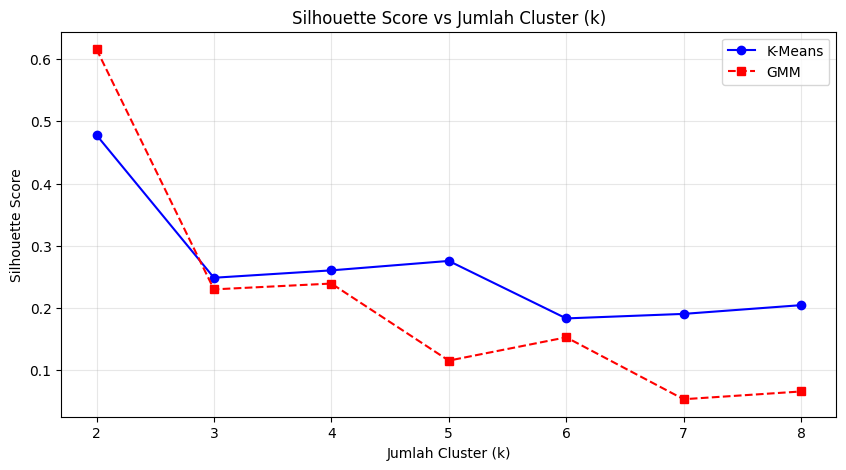

📌 Jumlah cluster optimal berdasarkan Silhouette Score: k = 2


In [12]:
# -----------------------------
# 6. TENTUKAN k OPTIMAL DENGAN SILHOUETTE SCORE
# -----------------------------
K_range = range(2, 9)
sil_scores_km = []
sil_scores_gmm = []

for k in K_range:
    # K-Means
    km = KMeans(n_clusters=k, random_state=42)
    labels_km_temp = km.fit_predict(X_scaled)
    sil_km = silhouette_score(X_scaled, labels_km_temp)
    sil_scores_km.append(sil_km)

    # GMM
    gmm_temp = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
    labels_gmm_temp = gmm_temp.fit_predict(X_scaled)
    sil_gmm = silhouette_score(X_scaled, labels_gmm_temp)
    sil_scores_gmm.append(sil_gmm)

# Plot perbandingan silhouette score
plt.figure(figsize=(10, 5))
plt.plot(K_range, sil_scores_km, 'o-', label='K-Means', color='blue')
plt.plot(K_range, sil_scores_gmm, 's--', label='GMM', color='red')
plt.title('Silhouette Score vs Jumlah Cluster (k)')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Pilih k dengan silhouette tertinggi (prioritaskan K-Means)
optimal_k = K_range[np.argmax(sil_scores_km)]
print(f"📌 Jumlah cluster optimal berdasarkan Silhouette Score: k = {optimal_k}")

In [13]:
# -----------------------------
# 7. JALANKAN MODEL DENGAN k OPTIMAL
# -----------------------------
# K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)
sil_km = silhouette_score(X_scaled, labels_km)

# GMM
gmm = GaussianMixture(n_components=optimal_k, random_state=42, covariance_type='full')
labels_gmm = gmm.fit_predict(X_scaled)
sil_gmm = silhouette_score(X_scaled, labels_gmm)

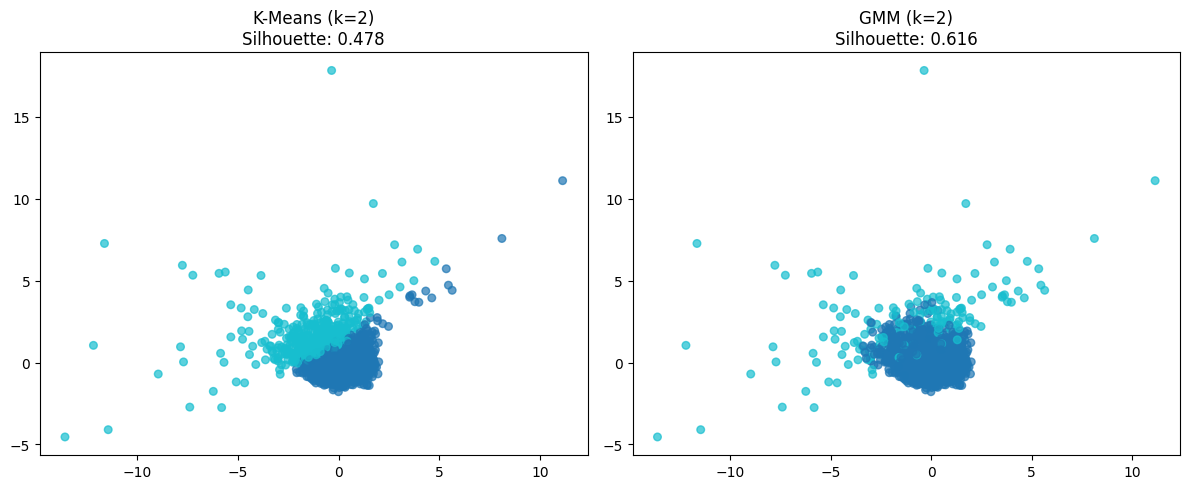

In [14]:
# -----------------------------
# 8. VISUALISASI PCA
# -----------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km, cmap='tab10', alpha=0.7, s=30)
plt.title(f'K-Means (k={optimal_k})\nSilhouette: {sil_km:.3f}')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_gmm, cmap='tab10', alpha=0.7, s=30)
plt.title(f'GMM (k={optimal_k})\nSilhouette: {sil_gmm:.3f}')

plt.tight_layout()
plt.show()